## Evaluating machine-learning models

In [2]:
import numpy as np

#### Training, validation, and test sets

Splitting your data into training, validation, and test sets may seem straightforward, but there are a few advanced ways to do it that can come in handy when **little data** is
available. 

Let’s review three classic evaluation recipes: **simple hold-out validation**, **Kfold validation**, and **iterated K-fold validation with shuffling**.

#### SIMPLE HOLD-OUT VALIDATION

Set apart some fraction of your data as your test set. Train on the remaining data, and evaluate on the test set.

In [4]:
num_validation_samples = 10000 

np.random.shuffle(data)# Shuffling the data is usually appropriate.

validation_data = data[:num_validation_samples] #Defines the validation set

data = data[num_validation_samples:] 

training_data = data[:] # Defines the training set

## Trains a model on the training data, and evaluates it on the validation data
model = get_model()
model.train(training_data)
validation_score = model.evaluate(validation_data)

# At this point you can tune your model,
# retrain it, evaluate it, tune it again...

## Once you’ve tuned your hyperparameters, it’s common to train your final model from scratch on all non-test data available.

model = get_model()
model.train(np.concatenate([training_data, validation_data]))
test_score = model.evaluate(test_data)

NameError: name 'data' is not defined

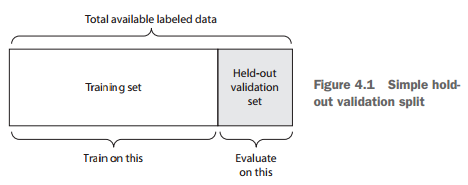

It suffers from one flaw: if little data is available, then your validation and test sets may contain too few samples to be statistically representative of the data at hand. 

#### K-FOLD VALIDATION

With this approach, you split your data into K partitions of equal size. For each partition i, train a model on the remaining K – 1 partitions, and evaluate it on partition i.

Your final score is then the averages of the K scores obtained. 
This method is helpful when the performance of your model shows significant *variance* based on your train test split. 

Like hold-out validation, this method doesn’t exempt you from using a distinct validation set for model calibration.

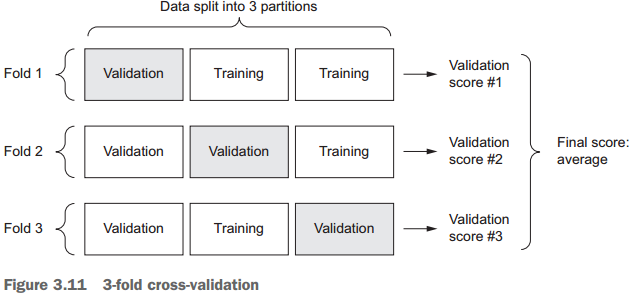

In [5]:
k = 4
num_validation_samples = len(data) // k
np.random.shuffle(data)
validation_scores = []

for fold in range(k):
    validation_data = data[num_validation_samples * fold: num_validation_samples * (fold + 1)]

    
    ## Uses the remainder of the data as training data. Note that the + operator is list concatenation, not summation.
    training_data = data[:num_validation_samples * fold] + 
                    data[num_validation_samples * (fold + 1):] 

    model = get_model()
    model.train(training_data)
    
    validation_score = model.evaluate(validation_data)

    validation_scores.append(validation_score)

validation_score = np.average(validation_scores) # Validation score: average of the validation scores of the k folds

## Trains the final model on all nontest data available
model = get_model()
model.train(data)
test_score = model.evaluate(test_data)

SyntaxError: invalid syntax (<ipython-input-5-b71c99db2614>, line 11)

#### ITERATED K-FOLD VALIDATION WITH SHUFFLING

This one is for situations in which you have relatively little data available and you need to evaluate your model as precisely as possible. 

It consists of applying K-fold validation multiple times, shuffling the data every time before splitting it K ways. The final score is the average of the scores obtained at each run of K-fold validation. Note that you end up training and evaluating P × K models (where P is the number of iterations you use), which can very expensive.

#### Things to keep in mind

##### Data representativeness

You want both your training set and test set to be representative of the data at hand. You usually should randomly shuffle your data before splitting it into training and test sets. 

##### The arrow of time

If you’re trying to predict the future given the past (for example, tomorrow’s weather, stock movements, and so on), you should not randomly shuffle your data before splitting it, because doing so will create a *temporal leak*: your model will effectively be trained on data from the future. 

In such situations, you should always make sure all data in your test set is posterior to the data in the training set.

##### Redundancy in your data

If some data points in your data appear twice (fairly common with real-world data), then shuffling the data and splitting it into a training set and a validation set will result in redundancy between the training and validation sets.

### Data preprocessing, feature engineering, and feature learning

How do you prepare the input data and targets before feeding them into a neural network? Many data-preprocessing and feature-engineering techniques are domain specific (for example, specific to text data or image data)

#### Data preprocessing for neural networks

##### VECTORIZATION

All inputs and targets in a neural network must be tensors of floating-point data (or, in specific cases, tensors of integers).

Whatever data you need to process—sound, images, text—you must first turn into tensors, a step called *data vectorization*. 

For instance, in the two previous text-classification examples, we started from text represented as lists of integers (standing for sequences of words), and we used one-hot
encoding to turn them into a tensor of float32 data. 

In the examples of classifying digits and predicting house prices, the data already came in vectorized form, so you were able to skip this step

##### VALUE NORMALIZATION

In general, it isn’t safe to feed into a neural network data that takes 

* relatively large values (for example, multidigit integers, which are much larger than the initial values taken by the weights of a network) or 

* data that is heterogeneous (for example, data where one feature is in the range 0–1 and another is in the range 100–200). 

Doing so can trigger large gradient updates that will prevent the network from converging. 

To make learning easier for your network, your data should have the following characteristics:

* Take small values—Typically, most values should be in the 0–1 range.
* Be homogenous—That is, all features should take values in roughly the same range.

Additionally, the following stricter normalization practice is common and can help, although it isn’t always necessary (for example, you didn’t do this in the digit-classification example):

* Normalize each feature independently to have a mean of 0.
* Normalize each feature independently to have a standard deviation of 1.

In [6]:
x -= x.mean(axis=0)
x /= x.std(axis=0)

NameError: name 'x' is not defined

##### HANDLING MISSING VALUES

In general, with neural networks, it’s safe to input missing values as 0, with the condition that 0 isn’t already a meaningful value. 

The network will learn from exposure to the data that the value 0 means missing data and will start ignoring the value.

If you’re expecting missing values in the test data, but the network was trained on data without any missing values, the network won’t have learned to ignore missing values! 

In this situation, you should artificially generate training samples with missing entries: copy some training samples several times, and drop some of the features that you expect are likely to be missing in the test data.

#### Feature engineering

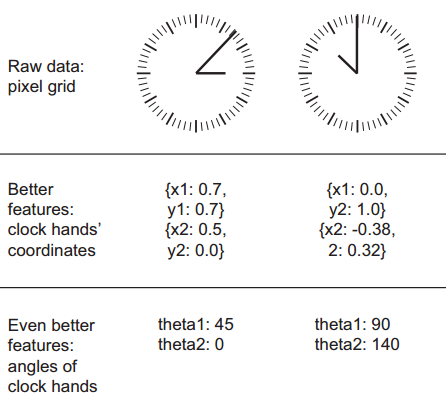

Before deep learning, feature engineering used to be critical, because classical shallow algorithms didn’t have hypothesis spaces rich enough to learn useful features
by themselves. The way you presented the data to the algorithm was essential to its success. 

For instance, before convolutional neural networks became successful on the MNIST digit-classification problem, solutions were typically based on hardcoded features such as the number of loops in a digit image, the height of each digit in an
image, a histogram of pixel values, and so on.

Fortunately, modern deep learning removes the need for most feature engineering, because neural networks are capable of automatically extracting useful features from raw data. Does this mean you don’t have to worry about feature engineering as long as you’re using deep neural networks? No, for two reasons:
    
* Good features still allow you to solve problems more elegantly while using fewer resources. For instance, it would be ridiculous to solve the problem of reading a clock face using a convolutional neural network.

* Good features let you solve a problem with far less data. The ability of deeplearning models to learn features on their own relies on having lots of training data available; if you have only a few samples, then the information value in  their features becomes critical.    

### Overfitting and underfitting

*Optimization* refers to the process of adjusting a model to get the best performance possible on the training data (the learning in machine learning)

*generalization* refers to how well the trained model performs on data it has never seen before. 

The goal of the game is to get good generalization, of course, but **you don’t control generalization; you can only adjust the model based on its training data.**

At the beginning of training, optimization and generalization are correlated: 

The lower the loss on training data, the lower the loss on test data. While this is happening,
your model is said to be *underfit*: there is still progress to be made; the network hasn’t
yet modeled all relevant patterns in the training data. 

But after a certain number of iterations on the training data, generalization stops improving, and validation metrics stall and then begin to degrade: the model is starting to *overfit*: 

It’s beginning to learn patterns that are specific to the training data but that are misleading or irrelevant when it comes to new data

To prevent a model from learning misleading or irrelevant patterns found in the
training data: 

**The best solution is to get more training data: A model trained on more data will naturally generalize better.**

The next-best solution is to modulate the quantity of information that your model is allowed to store or to add constraints on what information it’s allowed to store. 

If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

The processing of fighting overfitting this way is called **regularization**. Let’s review some of the most common regularization techniques:

##### Reducing the network’s size

The simplest way to prevent overfitting is to reduce the size of the model: 
the number of learnable parameters in the model (which is determined by the number of layers
and the number of units per layer).

In deep learning, the number of learnable parameters in a model is often referred to as the model’s *capacity*. 

Intuitively, a model with more parameters has more memorization capacity and therefore can easily learn a perfect dictionary-like mapping between training samples and their targets—a mapping without any generalization power. For instance, a model with 500,000 binary parameters could easily be made to learn the class of every digit in the MNIST training set:

we’d need only 10 binary parameters for each of the 50,000 digits. But such a model
would be useless for classifying new digit samples. 

**Always keep this in mind: deeplearning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.**

At the same time, keep in mind that you should use models that have enough parameters that they
don’t underfit: your model shouldn’t be starved for memorization resources. 

    
**There is a compromise to be found between too much capacity and not enough capacity**

Unfortunately, there is no magical formula to determine the right number of layers or the right size for each layer. 

You must evaluate an array of different architectures (on your validation set, not on your test set, of course) in order to find the correct model size for your data. 

**The general workflow to find an appropriate model size is to start with relatively few layers and parameters, and increase the size of the layers or add new layers until you see diminishing returns with regard to validation loss.**

Let’s try this on the movie-review classification network. The original network is shown next.

#### Original model

In [7]:
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

ModuleNotFoundError: No module named 'keras'

#### Version of the model with lower capacity

In [8]:
model = models.Sequential()
model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'models' is not defined

#### Version of the model with higher capacity

In [9]:
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'models' is not defined

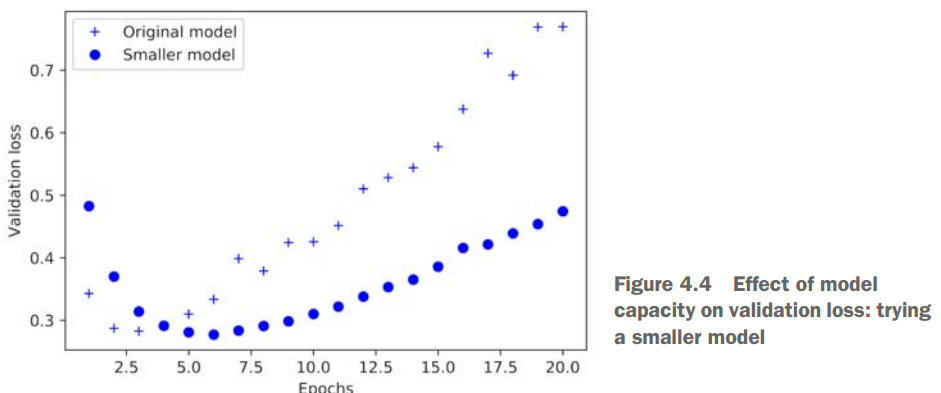

The smaller network starts overfitting later than the reference network (after six epochs rather than four), and its performance degrades more slowly once it sstarts overfitting.

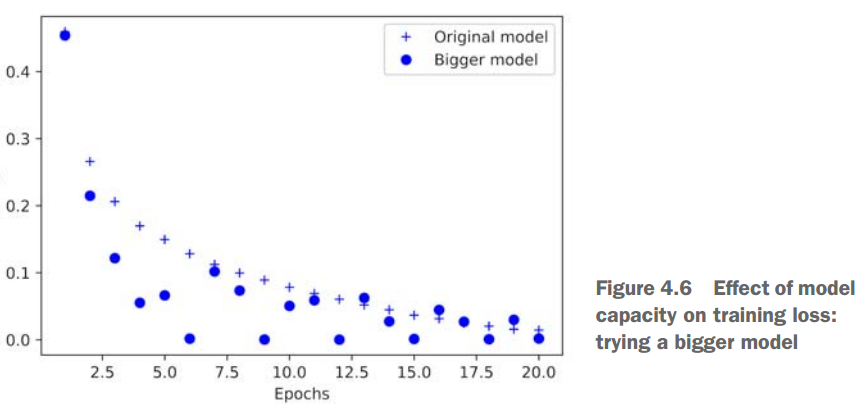

The bigger network starts overfitting almost immediately, after just one epoch, and it overfits much more severely. Its validation loss is also noisier.

##### Adding weight regularization

A common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights to take only small values, which makes the
distribution of weight values more regular:

* L1 regularization The cost added is proportional to the absolute value of the weight coefficients (the L1 norm of the weights).
* L2 regularization—The cost added is proportional to the square of the value of the weight coefficients (the L2 norm of the weights). L2 regularization is also called *weight decay* in the context of neural networks. 

In Keras, weight regularization is added by passing *weight regularizer instances* to layers
as keyword arguments. 

Let’s add L2 weight regularization to the movie-review classification network.

#### Adding L2 weight regularization to the model

In [11]:
from keras import regularizers

model = models.Sequential()
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

ModuleNotFoundError: No module named 'keras'

Note that because this penalty is *only added at training time*, the loss for this network will be much higher at training than at test time.

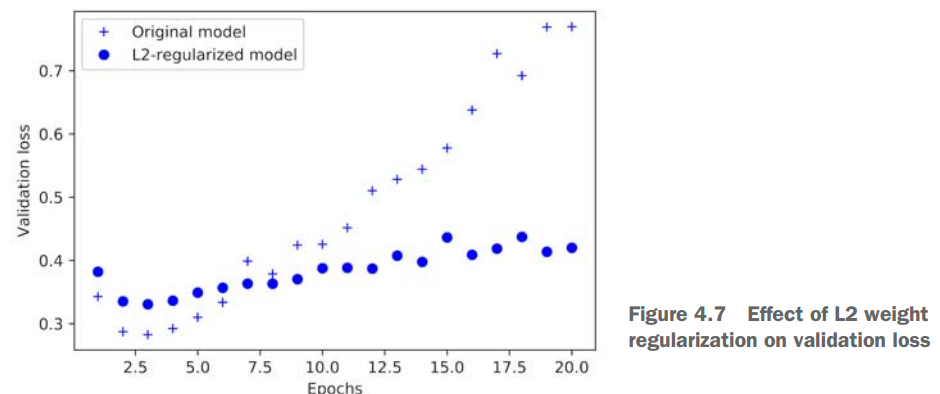

As an alternative to L2 regularization, you can use one of the following Keras weight regularizers.

#### Different weight regularizers available in Keras

In [12]:
from keras import regularizers
regularizers.l1(0.001) #L1 regularization
regularizers.l1_l2(l1=0.001, l2=0.001) #Simultaneous L1 and L2 regularization

ModuleNotFoundError: No module named 'keras'

##### Adding dropout

Dropout, applied to a layer, consists of randomly dropping out (setting to zero) a number of output features of the layer during training.

[0.2, 0.5, 1.3, 0.8, 1.1] ==>  [0, 0.5, 1.3, 0, 1.1]

The *dropout rate* is the fraction of the features that are zeroed out; it’s usually set between 0.2 and 0.5. 

**At test time, no units are dropped out; instead, the layer’s output values are scaled down by a factor equal to the dropout rate, to balance for the fact that more units are active than at training time.**

Consider a Numpy matrix containing the output of a layer, ```layer_output ```, of
shape ```(batch_size, features)```.

At **training time**, we zero out at random a fraction of the values in the matrix:

In [15]:
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) #At training time, drops out 50% of the units in the output

NameError: name 'layer_output' is not defined

At **test time**, we scale down the output by the dropout rate. Here, we scale by 0.5 (because we previously dropped half the units):

In [16]:
layer_output *= 0.5 #At test time

NameError: name 'layer_output' is not defined

Note that this process can be implemented by doing both operations at training time and leaving the output unchanged at test time, which is often the way it’s implemented in practice:

In [17]:
layer_output *= np.random.randint(0, high=2, size=layer_output.shape) #At training time scaling down in this case.
layer_output /= 0.5 #Note that we’re scaling up rather  

NameError: name 'layer_output' is not defined

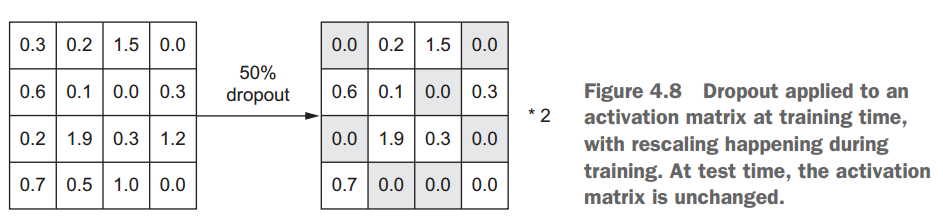

The core idea is that introducing noise in the output values of a layer can break up happenstance patterns that aren’t significant (what Hinton refers to as conspiracies), which the network will start memorizing if no noise is present.

In Keras, you can introduce dropout in a network via the Dropout layer, which is
applied to the output of the layer right before it:

In [18]:
model.add(layers.Dropout(0.5))

NameError: name 'model' is not defined

#### Adding dropout to the IMDB network

In [19]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

NameError: name 'models' is not defined

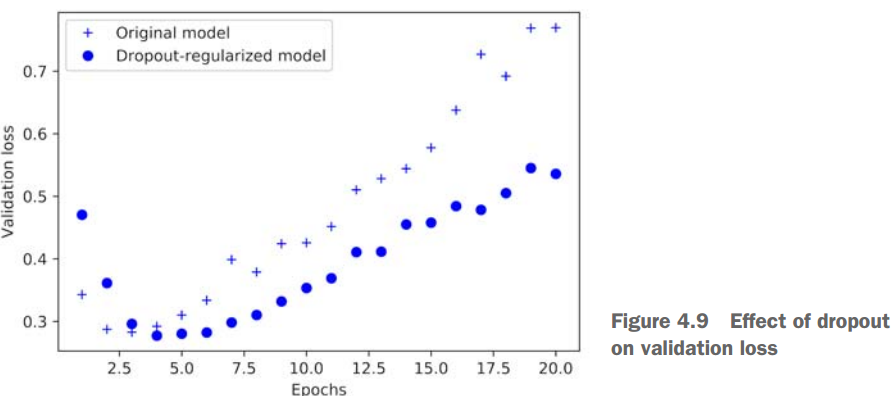

To recap, these are the most common ways to prevent overfitting in neural networks:
* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

## The universal workflow of machine learning

### 1 Defining the problem and assembling a dataset

* What will your input data be? What are you trying to predict? You can only learn to predict something if you have available training data: for example, you can only learn to classify the sentiment of movie reviews if you have both movie reviews and sentiment annotations available. As such, data availability is usually the limiting factor at this stage (unless you have the means to pay people to collect data for you).

* What type of problem are you facing? Is it binary classification? Multiclass classification? Scalar regression? Vector regression? Multiclass, multilabel classification? Something else, like clustering, generation, or reinforcement learning? Identifying the problem type will guide your choice of model architecture, loss function, and so on.

* You hypothesize that your outputs can be predicted given your inputs.

* You hypothesize that your available data is sufficiently informative to learn the  relationship between inputs and outputs.

### 2 Choosing a measure of success

To achieve success, you must define what you mean by success-accuracy? Precision and recall? Customer-retention rate? 

For balanced-classification problems, where every class is equally likely, accuracy and
area under the receiver operating characteristic curve (ROC AUC) are common metrics. 

For class-imbalanced problems, you can use precision and recall. 

For ranking problems or multilabel classification, you can use mean average precision.

### 3 Deciding on an evaluation protocol

* Maintaining a hold-out validation set: The way to go when you have plenty of data
* Doing K-fold cross-validation—The right choice when you have too few samples for hold-out validation to be reliable
* Doing iterated K-fold validation—For performing highly accurate model evaluation when little data is available

### 4 Preparing your data

* Your data should be formatted as tensors.
* The values taken by these tensors should usually be scaled to small values: for example, in the [-1, 1] range or [0, 1] range.
* If different features take values in different ranges (heterogeneous data), then the data should be normalized.
* You may want to do some feature engineering, especially for small-data problems.

### 5 Developing a model that does better than a baseline

Your goal at this stage is to achieve *statistical power*: that is, to develop a small model
that is capable of beating a dumb baseline. 

In the MNIST digit-classification example, anything that achieves an accuracy greater than 0.1 can be said to have statistical power; in the IMDB example, it’s anything with an accuracy greater than 0.5.

Note that it’s not always possible to achieve statistical power. If you can’t beat a random baseline after trying multiple reasonable architectures, it may be that the answer to the question you’re asking isn’t present in the input data.

Remember that you make two hypotheses:
* You hypothesize that your outputs can be predicted given your inputs.
* You hypothesize that the available data is sufficiently informative to learn the relationship between inputs and outputs.

Assuming that things go well, you need to make three key choices to build your first working model:

* **Last-layer activation**: This establishes useful constraints on the network’s output. For instance, the IMDB classification example used sigmoid in the last layer; the regression example didn’t use any last-layer activation; and so on.

* **Loss function**: This should match the type of problem you’re trying to solve. For instance, the IMDB example used binary_crossentropy, the regression example used mse, and so on.

* **Optimization configuration**: What optimizer will you use? What will its learning rate be? In most cases, it’s safe to go with rmsprop and its default learning rate.

Sometimes there is no easy way to turn a metric into a loss function. For instance, the widely used classification metric ROC AUC can’t be directly optimized. Hence, in classification tasks, it’s common to optimize for a proxy metric of ROC AUC, such as crossentropy. In general, you can hope that the lower the crossentropy gets, the higher the ROC AUC will be.

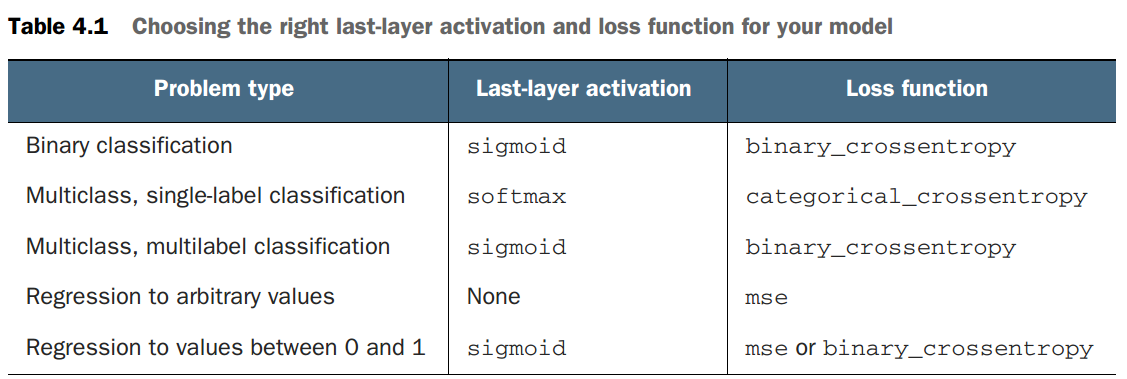

### 6 Scaling up: developing a model that overfits

Once you’ve obtained a model that has statistical power, the question becomes: 
is your model sufficiently powerful?
Does it have enough layers and parameters to properly model the problem at hand? 

For instance, a network with a single hidden layer with two units would have statistical power on MNIST but wouldn’t be sufficient to solve the problem well. 

Remember that the universal tension in machine learning is between optimization and generalization; the ideal model is one that stands right at the border between underfitting and overfitting; between undercapacity and overcapacity. 


To figure out how big a model you’ll need, you must develop a model that overfits.
This is fairly easy:
1 Add layers.
2 Make the layers bigger.
3 Train for more epochs.

Always monitor the training loss and validation loss, as well as the training and validation values for any metrics you care about. When you see that the model’s performance on the validation data begins to degrade, you’ve achieved overfitting.

### 7 Regularizing your model and tuning your hyperparameters

This step will take the most time: you’ll repeatedly modify your model, train it, evaluate on your validation data (not the test data, at this point), modify it again, and
repeat, until the model is as good as it can get. 

* Add dropout.
* Try different architectures: add or remove layers.
* Add L1 and/or L2 regularization.
* Try different hyperparameters (such as the number of units per layer or the learning rate of the optimizer) to find the optimal configuration.
* Optionally, iterate on feature engineering: add new features, or remove features that don’t seem to be informative.

### Chapter summary
* Define the problem at hand and the data on which you’ll train. Collect
this data, or annotate it with labels if need be.
* Choose how you’ll measure success on your problem. Which metrics will
you monitor on your validation data?
* Determine your evaluation protocol: hold-out validation? K-fold validation? Which portion of the data should you use for validation?
* Develop a first model that does better than a basic baseline: a model with
statistical power.
* Develop a model that overfits.
* Regularize your model and tune its hyperparameters, based on performance on the validation data. A lot of machine-learning research tends to
focus only on this step—but keep the big picture in mind.